# Random Walk: TD vs MC comparison

In this notebook we compare the performance of temporal difference (TD(0)) and Monte Carlo.
The example we consider is a so-called Markov reward process,
i.e. a Markov decision process without actions.

For a more detailed description see Example 6.2, page 125, in Sutton & Barto.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

The environment is a finite, integer random walk of a given length,
with the agent starting in the middle of the way.

Each step they go left or right with equal probability.

The two outermost states (`0` and `length-1`) are terminal.

When the agent enters state `length-1` they receive a reward of +1, anytime else 0.

In [3]:

class RandomWalk:
    def __init__(self, length:int):
        self.length = length
        self.position = 0
        self.reset()
        self.TERMINAL_POSITIONS = [0, self.length-1]
    
    def step(self)->None:
        direction = np.random.choice([-1, 1])
        self.position += direction
        
    
    def reward(self) -> int:
        return int(self.position == self.length-1)
        
    
    def reset(self) -> None:
        self.position = self.length // 2

    def is_terminal(self) -> bool:
        return self.position in self.TERMINAL_POSITIONS
    
    def __str__(self):
        return ' '.join(['x' if i == self.position else '.' for i in range(self.length)])



Set the length of the random walk used below. As this is an episodic task, we can set $\gamma$ to 1. We also take a discount value smaller than 1 to better illustrate how the algorithm behave.

In [4]:
LENGTH = 7
GAMMA_NO_DISCOUNT = 1
GAMMA = 0.9

Create an instance and test the environment

In [5]:
rw = RandomWalk(LENGTH)

In [6]:
rw.reset()
while not ( rw.is_terminal()):
    rw.step()
    print(rw)

. . . . x . .
. . . x . . .
. . . . x . .
. . . . . x .
. . . . . . x


## 1. Monte Carlo

We implement Monte Carlo prediction, roughly following the pseudo-code on page 114 of [Sutton & Barto](http://incompleteideas.net/book/RLbook2020trimmed.pdf#page=114).
The algorithm is changed by using a constant update rate $\alpha$, rather than averaging over all previous returns.

In [7]:
# Initialize:
# V(s) <- arbitrarily

# Loop forever (for each episode):
    # Generate an episode: S0, A0, R1, S1, A1, R2, ..., ST-1, AT-1, RT
    # G <- 0
    # Loop for each step of episode, t = T-1, T-2, ..., 0:
        # G <- GAMMA * G + Rt+1
        # Unless St appears in S0, A0, S1, A1, ..., St-1, At-1:
            # V(St) <- V(St) + alpha * (G - V(St))

First, we define a helper function to generate an episode.

In [8]:
def generateEpisode(randomWalk: RandomWalk):
    # Reset random walk
    randomWalk.reset()
    path=[randomWalk.position]
    reward = [0]
    
    # Take steps until state is terminal, recording path and rewards
    while not ( randomWalk.is_terminal() ):
        randomWalk.step()
        path.append(randomWalk.position)
        reward.append(randomWalk.reward())
    
    # Return path and rewards
    return path, reward

Next, we define the code for a single episode of MC.
The value function is passed as `values` and updated in place.

In [9]:
def give_return(reward:list,gamma:float) -> float:
    if len(reward)==0:
        return 0
    return reward[0]+gamma*give_return(reward[1:],gamma)

def monteCarloEpisode(randomWalk: RandomWalk, values, alpha, gamma=1):
    # Generate an episode
    path, reward = generateEpisode(randomWalk)
    
    # Update values
    for state in range(randomWalk.length):
        if state in path:
            index = path.index(state)
            values[state] += alpha * (give_return(reward[index:],gamma) - values[state])

    return values


Finally, we perform MC by running many episodes. We will compare several parameters for the learning rate. All going to be fixed but one following $\dfrac{1}{n}$

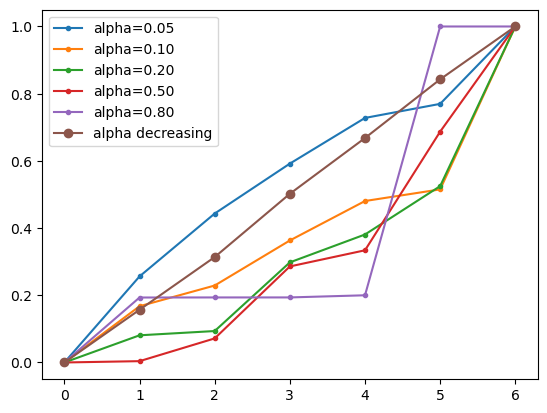

In [10]:
# Perform MC by running many episodes
NB_EPISODES = 1000
for alpha in [0.05,0.1,0.2,0.5,0.8]:
    values = np.zeros(rw.length)
    endvalue= 0
    for index in range(NB_EPISODES):
        values = monteCarloEpisode(rw, values,alpha)
    plt.plot(np.arange(rw.length),values,'.-',label=f"alpha={alpha:.2f}")
values = np.zeros(rw.length)
endvalue=0
for index in range(NB_EPISODES):
    values = monteCarloEpisode(rw, values,1/(index+1))
plt.plot(np.arange(rw.length),values,'o-',label=f"alpha decreasing")

plt.legend()
plt.show()

We are also interested to see what happens in the first few steps. We use here the two values of $\gamma$.

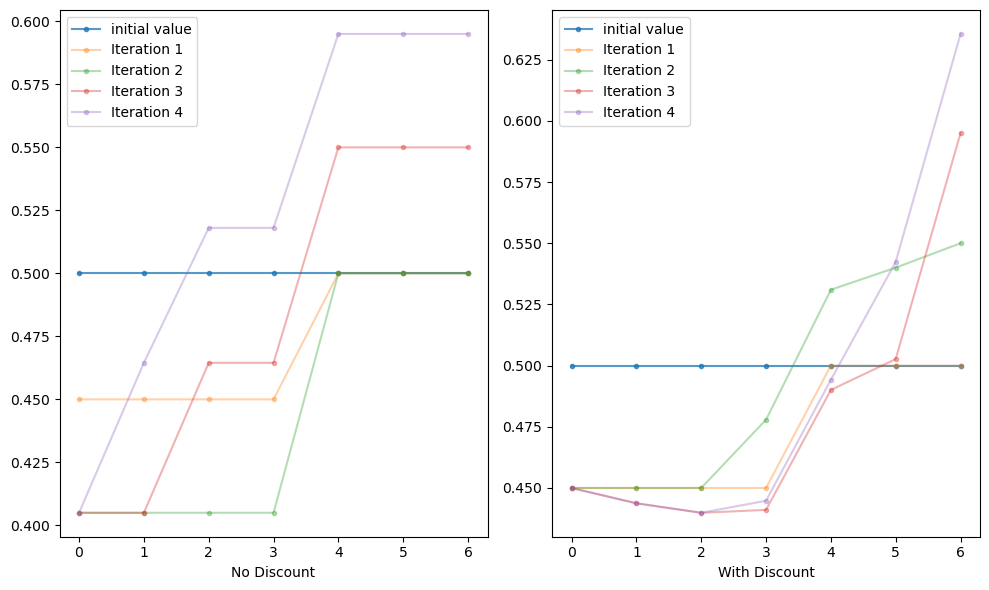

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,6))
for index,gamma in enumerate([GAMMA_NO_DISCOUNT,GAMMA]):
    values = 0.5 * np.ones(rw.length)
    ax[index].plot(np.arange(rw.length), values, '.-',label='initial value',alpha=0.75)
    for iteration in range(4):
        values=monteCarloEpisode(rw,values,alpha=0.1,gamma=gamma)
        ax[index].plot(np.arange(rw.length), values, '.-',label=f'Iteration {iteration+1}',alpha=0.35)
    ax[index].legend()
    ax[index].set_xlabel(["No Discount", "With Discount"][index])
fig.tight_layout()
plt.show()

## 2. TD(0)

Next, we define the code for a single episode of TD(0).
The value function is passed as `values` and updated in place.

In [12]:
## TD(0) to estimate value function V

# Algorithm parameter alpha
# Initialize V(s) such that V(terminal)=0
# for each episode do:
    # Initialize S
    # repeat:
        # Take step, observe R, S'
        # V(S) <- V(S) + alpha * (R + V(S') − V (S))
        # S <- S'
    # until S is terminal

In [13]:

def tdEpisode(randomWalk: RandomWalk, values, alpha,gamma=1):
    # Initialize new random walk
    randomWalk.reset()

    # Generate an episode, updating values in the process
    while not (randomWalk.is_terminal()):
        curent_state = randomWalk.position
        randomWalk.step()
        next_state = randomWalk.position
        reward = randomWalk.reward()
        values[curent_state] += alpha * (reward + gamma*values[next_state]- values[curent_state])

    return values

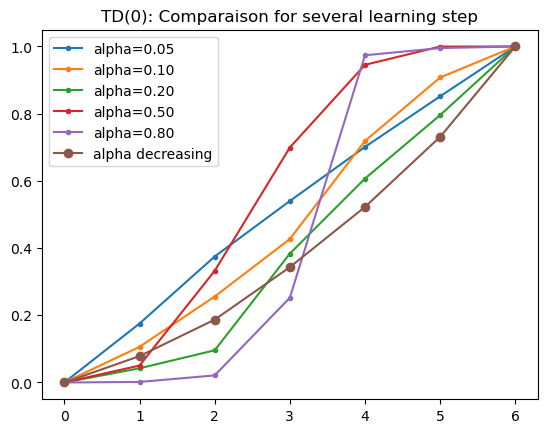

In [25]:
# Perform TD(0) by running many episodes
NB_EPISODES = 1000
for alpha in [0.05,0.1,0.2,0.5,0.8]:
    values = np.zeros(rw.length)
    for index in range(NB_EPISODES):
        values = tdEpisode(rw, values,alpha)
    values[-1] = 1
    plt.plot(np.arange(rw.length),values,'.-',label=f"alpha={alpha:.2f}")
values = np.zeros(rw.length)
for index in range(NB_EPISODES):
    values = tdEpisode(rw, values,1/(index+1))
values[-1] = 1
plt.plot(np.arange(rw.length),values,'o-',label=f"alpha decreasing")
plt.title("TD(0): Comparaison for several learning step")
plt.legend()
plt.show()

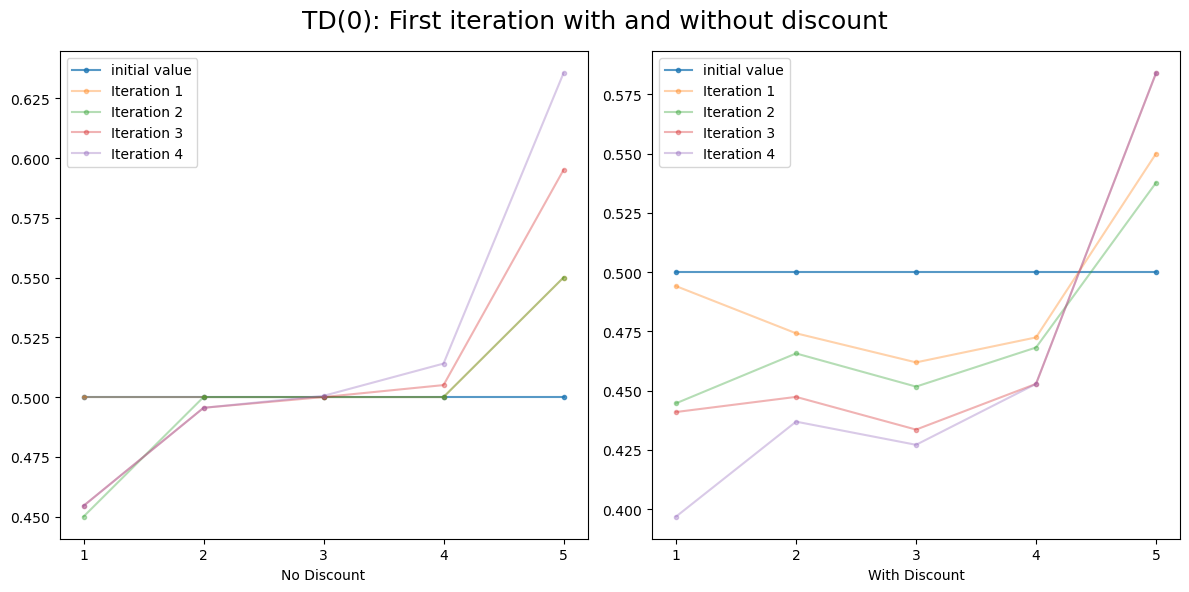

In [24]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
for index, gamma in enumerate([GAMMA_NO_DISCOUNT,GAMMA]):
    values = 0.5 * np.ones(rw.length)
    values[rw.TERMINAL_POSITIONS]=0
    ax[index].plot(np.arange(rw.length-2)+1, values[1:-1], '.-',label='initial value',alpha=0.75)
    for iteration in range(4):
        values=tdEpisode(rw,values,alpha=0.1,gamma=gamma)
        ax[index].plot(np.arange(rw.length-2)+1, values[1:-1], '.-',label=f'Iteration {iteration+1}',alpha=0.35)
    ax[index].legend()
    ax[index].set_xticks(range(1,6))
    ax[index].set_xlabel(["No Discount", "With Discount"][index])
plt.suptitle("TD(0): First iteration with and without discount", fontsize=18)
plt.tight_layout()
plt.show()

## 3. TD($\lambda$)

This is an extra part to implement the algorithm using TD($\lambda$). It is well known that Monte-Carlo is an unbiased high-variance estimation, and that TD(0) is a biased low-variance estimation. TD($\lambda$) methods provide a way to balance the bias and the variance with the parameter $\lambda \in [0,1)$. With $\lambda = 0$, we get back to TD(0), and $lim_{\lambda\rightarrow 1} TD(\lambda)$ is Monte-Carlo. The estimation for the return is then $$(1-\lambda)\sum \lambda^i G_{(i)}\\ G_{(i)}= \sum_{k=1}^i \gamma^{k-1}R_k+\gamma^{i+1}v(S_{t+i+1})$$
Here $G_{(i)}$ are the estimation that consider the real value of the first $i$ steps, then use the given estimation. 
The algorithm is a little bit more complex.

In [ ]:
def give_i_return(reward:list,path:list,index_iter:i, values:np.array,gamma:float) -> float:
    if len(reward)==0:
        return 0
    return reward[0]+gamma*give_return(reward[1:],gamma)

def give_lamdba_return(reward:list,path:list,values:np.array,lambda:float,gamma:float):
    pass


def tdLambdaEpisode(randomWalk: RandomWalk, values, alpha, lambda:float,gamma=1):
    # Generate an episode
    path, reward = generateEpisode(randomWalk)
    # Update values
    for state in range(randomWalk.length):
        if state in path:
            index = path.index(state)
            values[state] += alpha * (give_lambda_return(reward[index:],pathreward[index:],lambda,gamma) - values[state])

    return values


## Comparison

Note that the true value of state $s$ is $s / (LENGTH - 1)$.
We use this to compare the error made by each method.

In [ ]:
TRUE_VALUES = [i / (LENGTH - 1) for i in range(LENGTH)]

def computeRMS(values):
    errors = [v - t for v, t in zip(values[1:-1], TRUE_VALUES[1:-1])]
    return np.sqrt(np.mean(np.square(errors)))

First we recreate the left graph from p. 125, Sutton & Barto, showing the value function for different numbers of episodes $n$.

In [ ]:
def plotValueSteps(showN, alpha):
    values = [0.5] * LENGTH
    values[0] = 0
    values[-1] = 0

    randomWalk = RandomWalk(LENGTH)
    
    n = np.max(showN) + 1
    
    # Perform TD, plotting the values of steps in showN
    # ...
    
    plt.plot(TRUE_VALUES[1:-1], linestyle='dashdot', label="true values")

    plt.legend()
    plt.show()

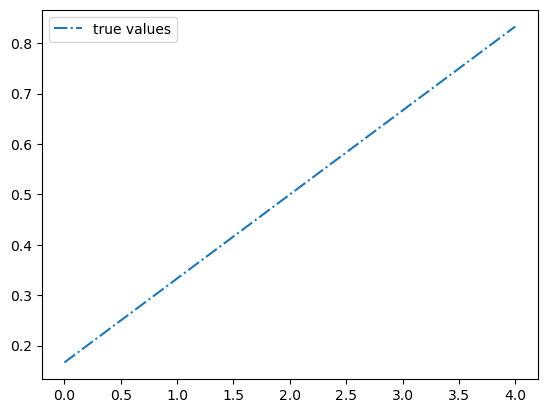

In [ ]:
plotValueSteps([0, 1, 10, 100], 0.1)

Next, we define a function that performs several TD/MC episodes and computes the RMS after each episode.

In [ ]:

def computeRMSs(alpha, nEpisodes, xxxEpisode):
    randomWalk = RandomWalk(LENGTH)
    rms = []
    values = [0.5] * LENGTH
    values[0] = 0
    values[-1] = 0
    for j in range(nEpisodes):
        xxxEpisode(randomWalk, values, alpha)
        rms.append(computeRMS(values))
    return rms


Using the function above,
we plot the RMS vs. the number of training episodes for both methods and different values of `alpha`.

MC...
0.01
0.02
0.03
0.04
TD...
0.01
0.05
0.1
0.2


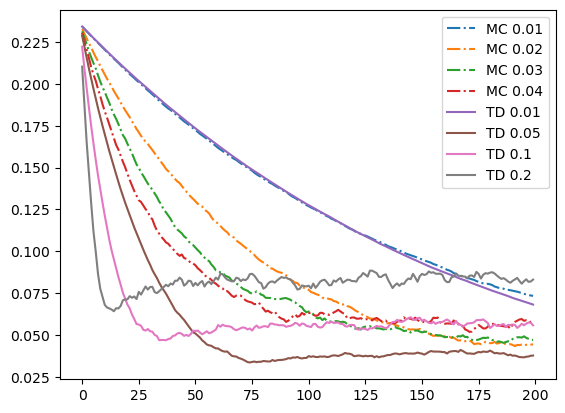

In [ ]:
# Compared alphas
alphasMC = [0.01, 0.02, 0.03, 0.04]
alphasTD = [0.01, 0.05, 0.10, 0.20]

# Number of episodes per experiment
nEpisodes = 200

# Number of experiments
nExperiments = 100

print('MC...')
for i, alpha in enumerate(alphasMC):
    print(alpha)
    rmsList = [computeRMSs(alpha, nEpisodes, monteCarloEpisode) for _ in range(nExperiments)]
    rms = np.mean(rmsList, axis=0)
    plt.plot(rms, linestyle='dashdot', label='MC {}'.format(alpha))

print('TD...')
for i, alpha in enumerate(alphasTD):
    print(alpha)
    rmsList = [computeRMSs(alpha, nEpisodes, tdEpisode) for _ in range(nExperiments)]
    rms = np.mean(rmsList, axis=0)
    plt.plot(rms, linestyle='solid', label='TD {}'.format(alpha))


plt.legend()
plt.show()
